# Hotdog Classifier

Inspired by [Hot Dog or Not Hot Dog – Convolutional Neural Network Course for Beginners](https://www.youtube.com/watch?v=nVhau51w6dM&t=4108s). This notebook shows examples working with inbalanced dataset and training a very simple CNN for binary classification.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms
from tqdm.auto import tqdm

In [ ]:
DATA_ROOT = '/content/sample_data/data'
IMG_SZ = 224
HOTDOG_LABEL = 55

train_tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((-45, 45)),
    # Resize the image into a fixed shape (height = width = IMG_SZ)
    transforms.Resize((IMG_SZ, IMG_SZ)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = IMG_SZ)
    transforms.Resize((IMG_SZ, IMG_SZ)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

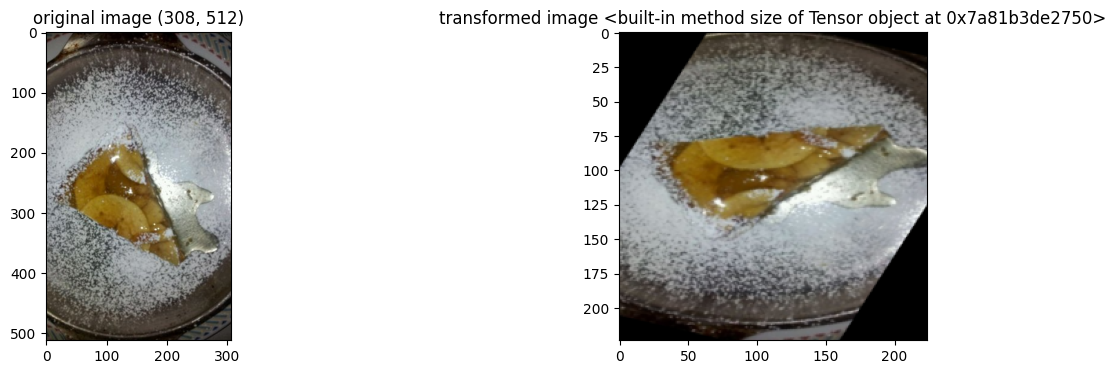

In [ ]:
## Test of transforms

import PIL.Image
import matplotlib.pyplot as plt

def imshow(img, transform):
    """helper function to show data augmentation
    :param img: path of the image
    :param transform: data augmentation technique to apply"""

    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'original image {img.size}')
    ax[0].imshow(img)
    img = transform(img)
    ax[1].set_title(f'transformed image {img.size}')
    ax[1].imshow(img.permute(1,2,0))

img = '/content/sample_data/data/food-101/images/apple_pie/1005649.jpg'
imshow(img, train_tfm)

In [ ]:
all_train_ds = datasets.Food101(DATA_ROOT, 'train', download=True,
                                transform=train_tfm,
                                target_transform=lambda y: float(y == HOTDOG_LABEL))
test_ds = datasets.Food101(DATA_ROOT, 'test', download=True,
                           transform=test_tfm,
                           target_transform=lambda y: float(y == HOTDOG_LABEL))
print(f'train size: {len(all_train_ds)}, test size: {len(test_ds)}')

train size: 75750, test size: 25250


In [ ]:
myseed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
import json

META_DIR = DATA_ROOT + '/food-101/meta'
labels = []
image_files = []
with open(META_DIR + "/train.json") as f:
    metadata = json.loads(f.read())

classes = sorted(metadata.keys())
class_to_idx = dict(zip(classes, range(len(classes))))

hotdog_begin, hotdog_end = -1, 0
for class_label, im_rel_paths in metadata.items():
    hotdog_begin = hotdog_end
    hotdog_end += len(im_rel_paths)
    if class_to_idx[class_label] == HOTDOG_LABEL:
      break
len(metadata), hotdog_begin, hotdog_end

(101, 63000, 63750)

In [ ]:
hotdog_idx = torch.arange(hotdog_begin, hotdog_end)
not_hotdog_idx_0 = torch.arange(0, hotdog_begin)
not_hotdog_idx_1 = torch.arange(hotdog_end, len(all_train_ds))
not_hotdog_idx = torch.concat([not_hotdog_idx_0, not_hotdog_idx_1])
hotdog_idx.shape, not_hotdog_idx_0.shape, not_hotdog_idx_1.shape, not_hotdog_idx.shape

(torch.Size([750]),
 torch.Size([63000]),
 torch.Size([12000]),
 torch.Size([75000]))

In [ ]:
from sklearn.model_selection import train_test_split

train_hotdog_idx, valid_hotdog_idx = train_test_split(hotdog_idx, test_size=0.2)

train_not_hotdog_idx, valid_not_hotdog_idx = train_test_split(not_hotdog_idx, test_size=0.2)

train_idx = torch.concat([train_not_hotdog_idx, train_hotdog_idx])
valid_idx = torch.concat([valid_not_hotdog_idx, valid_hotdog_idx])

train_hotdog_idx.shape, valid_hotdog_idx.shape, train_not_hotdog_idx.shape, valid_not_hotdog_idx.shape, train_idx.shape, valid_idx.shape

(torch.Size([600]),
 torch.Size([150]),
 torch.Size([60000]),
 torch.Size([15000]),
 torch.Size([60600]),
 torch.Size([15150]))

In [ ]:
train_ds = Subset(all_train_ds, train_idx)
valid_ds = Subset(all_train_ds, valid_idx)
print(f'train size: {len(train_ds)}, valid size: {len(valid_ds)}')

train size: 60600, valid size: 15150


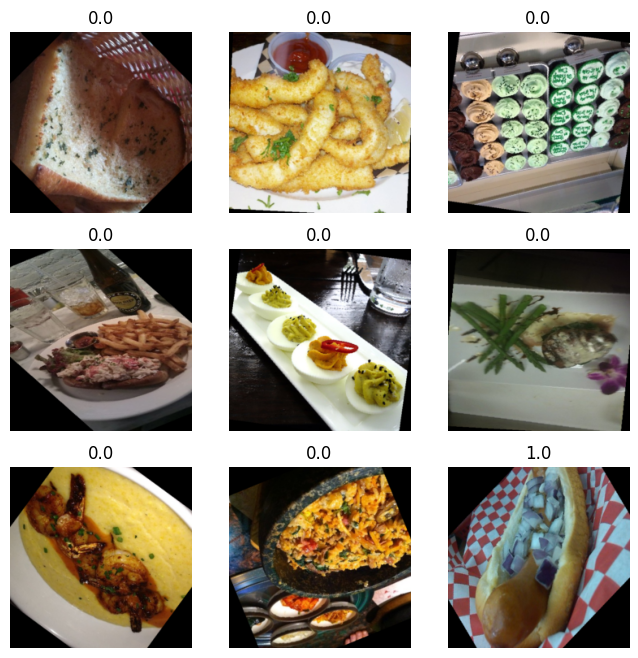

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  sample_idx = torch.randint(len(train_ds), size=(1,)).item()
  img, label = train_ds[sample_idx]
  figure.add_subplot(rows, cols, i);
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.permute(1,2,0))
plt.show()

## Resample inbalanced dataset

-------------------------
**start of test**

In [ ]:
# Copied from "https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452"
import numpy as np
import matplotlib.pyplot as plt

def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):

        idxs = batch[0][:, 0].tolist()
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

In [ ]:
new_ds = [[i, 0] for i in range(len(train_ds))]
for i in range(len(train_ds)-len(train_hotdog_idx), len(train_ds)):
  new_ds[i][1] = 1
ds = TensorDataset(torch.as_tensor(new_ds))

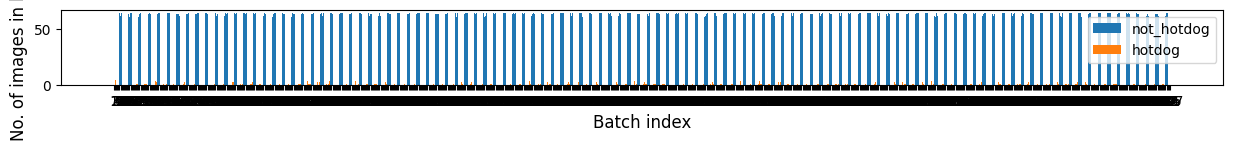

Avg Proportion of not_hotdog per batch: 6.335797254487856
Avg Proportion of hotdog per batch: 0.06335797254487856
Num. unique images seen: 60600/60600


In [ ]:
dl = DataLoader(ds, shuffle=True, batch_size=64)
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl, {0: "not_hotdog", 1: "hotdog"})

In [ ]:
class_counts = torch.tensor([100.0, 1.0])
sample_weights = [1.0/class_counts[0] for _ in range(len(train_ds))]
for i in range(len(train_ds)-len(train_hotdog_idx), len(train_ds)):
  sample_weights[i] = 1.0/class_counts[1]

In [ ]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds), replacement=True)

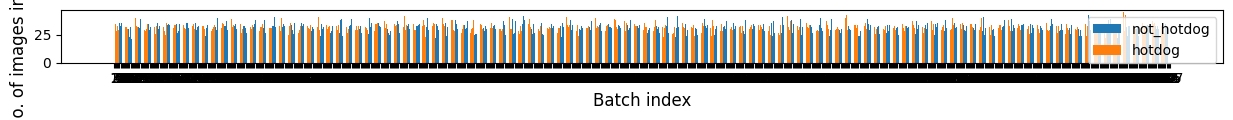

Avg Proportion of not_hotdog per batch: 3.1872228088701164
Avg Proportion of hotdog per batch: 3.2119324181626188
Num. unique images seen: 24295/60600


In [ ]:
dl = DataLoader(ds, sampler=sampler, batch_size=64)
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl, {0: "not_hotdog", 1: "hotdog"})

# NOTE: 24295/60600 unique images are seen, takes several epochs to see all images.

In [ ]:
train_dl = DataLoader(train_ds, sampler=sampler, batch_size=64)

for i, batch in enumerate(train_dl):
  labels = batch[1]
  num_hotdogs = torch.sum(labels == 1)
  num_not_hotdogs = torch.sum(labels == 0)
  print(f'num hotdogs: {num_hotdogs}, num not hotdogs: {num_not_hotdogs}')
  if i == 5: break

num hotdogs: 29, num not hotdogs: 35
num hotdogs: 34, num not hotdogs: 30
num hotdogs: 27, num not hotdogs: 37
num hotdogs: 29, num not hotdogs: 35
num hotdogs: 35, num not hotdogs: 29
num hotdogs: 33, num not hotdogs: 31


**end of test**

-------------------------

In [ ]:
BATCH_SZ = 64

sample_counts = [100.0, 1.0]
sample_weights = [1.0/sample_counts[0] for _ in range(len(train_ds))]
for i in range(len(train_ds)-len(train_hotdog_idx), len(train_ds)):
  sample_weights[i] = 1.0/sample_counts[1]

train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds), replacement=True)
train_dl = DataLoader(train_ds, sampler=train_sampler, batch_size=BATCH_SZ)

In [ ]:
sample_weights = [1.0/sample_counts[0] for _ in range(len(valid_ds))]
for i in range(len(valid_ds)-len(valid_hotdog_idx), len(valid_ds)):
  sample_weights[i] = 1.0/sample_counts[1]
valid_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(valid_ds), replacement=True)
valid_dl = DataLoader(valid_ds, sampler=valid_sampler, batch_size=BATCH_SZ)

## Training

In [ ]:
class HotdogClassifier(nn.Module):
  def __init__(self):
    super(HotdogClassifier, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, 3, 1, 1),    # 64x224x224
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),        # 64x112x112

        nn.Conv2d(64, 128, 3, 1, 1),  # 128x112x112
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),        # 128x56x56

        nn.Conv2d(128, 256, 3, 2, 1), # 256x28x28
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(256, 512, 3, 2, 1), # 512x14x14
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512, 512, 3, 2, 1), # 512x7x7
        nn.BatchNorm2d(512),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
          nn.Linear(512*7*7, 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, 1)
    )

  def forward(self, x):
    out = self.cnn(x)
    out = out.view(out.size()[0], -1)
    return self.fc(out)

In [ ]:
class HotdogResNetClassifier(nn.Module):
  def __init__(self):
    super(HotdogResNetClassifier, self).__init__()

    self.cnn_layer1 = nn.Sequential(
        nn.Conv2d(3, 64, 3, 1, 1),     # 64x224x224
        nn.BatchNorm2d(64),
    )

    self.cnn_layer2 = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),    # 64x224x224
        nn.BatchNorm2d(64),
    )

    self.cnn_layer3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 2, 1),    # 128x112x112
        nn.BatchNorm2d(128),
    )

    self.cnn_layer4 = nn.Sequential(
        nn.Conv2d(128, 128, 3, 1, 1),   # 128x112x112
        nn.BatchNorm2d(128),
    )

    self.cnn_layer5 = nn.Sequential(
        nn.Conv2d(128, 256, 3, 2, 1),   # 256x56x56
        nn.BatchNorm2d(256),
    )

    self.cnn_layer6 = nn.Sequential(
        nn.Conv2d(256, 256, 3, 1, 1),   # 256x56x56
        nn.BatchNorm2d(256),
    )

    # self.cnn_layer7 = nn.Sequential(
    #     nn.Conv2d(256, 512, 3, 2, 1),   # 512x28x28
    #     nn.BatchNorm2d(512),
    # )

    # self.cnn_layer8 = nn.Sequential(
    #     nn.Conv2d(512, 512, 3, 1, 1),   # 512x28x28
    #     nn.BatchNorm2d(512),
    # )

    self.fc_layer = nn.Sequential(
        nn.Linear(256 * 56 * 56, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 1)
    )

    self.relu = nn.ReLU()

  def forward(self, x):
    layers = [self.cnn_layer1, self.cnn_layer2,
              self.cnn_layer3, self.cnn_layer4,
              self.cnn_layer5, self.cnn_layer6]
    for i, layer in enumerate(layers):
      xout = layer(x)
      if i % 2 == 1:
        xout += x
      x = self.relu(xout)

    xout = x.view(x.size()[0], -1)
    xout = self.fc_layer(xout)
    return xout

In [ ]:
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 8
lr = 0.001;
weight_decay = 1e-5
patience = 100
mname = 'resnet' # vanilla or resnet
ckpt_name = DATA_ROOT + '/best.ckpt'
read_from_ckpt = False;

model = HotdogClassifier().to(device) if mname == 'vanilla' else HotdogResNetClassifier().to(device)
if read_from_ckpt and os.path.isfile(ckpt_name):
  print(f'Load model in {ckpt_name}')
  model.load_state_dict(torch.load(ckpt_name))

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

best_acc = 0
stale = 0

for epoch in range(num_epochs):
  model.train()

  train_losses = []
  train_accs = []

  for batch in tqdm(train_dl):
    imgs, labels = batch

    logits = model(imgs.to(device)).squeeze()

    loss = loss_fn(logits, labels.to(device))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    probs = (F.sigmoid(logits) > 0.5).float()
    acc = (probs == labels.to(device)).float().mean()

    train_losses.append(loss.item())
    train_accs.append(acc)

  train_loss = sum(train_losses) / len(train_losses)
  train_acc = sum(train_accs) / len(train_accs)
  print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

  model.eval()

  valid_losses = []
  valid_accs = []

  for batch in tqdm(valid_dl):
    imgs, labels = batch

    with torch.no_grad():
      logits = model(imgs.to(device)).squeeze()

      loss = loss_fn(logits, labels.to(device))

      probs = (F.sigmoid(logits) > 0.5).float()
      acc = (probs == labels.to(device)).float().mean()

      valid_losses.append(loss.item())
      valid_accs.append(acc)

  valid_loss = sum(valid_losses) / len(valid_losses)
  valid_acc = sum(valid_accs) / len(valid_accs)
  print(f'[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}')

  msg = f'[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}'
  msg += ' -> best' if valid_acc > best_acc else ''
  with open(f'{DATA_ROOT}/log.txt', 'a') as fid:
    fid.write(msg)

  if valid_acc > best_acc:
    print(f'Best model found at epoch {epoch}, saving model')
    torch.save(model.state_dict(), ckpt_name)
    best_acc = valid_acc
    stale = 0
  else:
    stale += 1
    if stale > patience:
      print(f'No improvment {patience} consecutive epochs, early stopping')
      break;

OutOfMemoryError: ignored

**Training results**

The result after running 3 epochs.

| Changes | Train loss | Tran acc | Valid loss | Valid acc| Conclusion |
----------|------------|------------|------------|------------|------------|
| Vanilla | 0.01945 | 0.99444 | 7.04466 | 0.5256 | Overfit |
| Augmentation | TBD |
| BatchNorm | 0.02290 | 0.99297 | 4.91820 | 0.50691 | Overfit |
| ResNet | TBD |
| Augmentation + BatchNorm | 0.33728 | 0.85029 | 1.02564 | 0.70994 |
| Augmentation + BatchNorm + ResNet| 0.51639 | 0.74235 | 0.57473 | 0.70742 | Best model |





## Testing

In [ ]:
test_dl = DataLoader(test_ds, shuffle=True, batch_size=9)

model_best = HotdogClassifier().to(device) if mname == 'vanilla' else HotdogResNetClassifier().to(device)
model_best.load_state_dict(torch.load(ckpt_name))
model_best.eval()

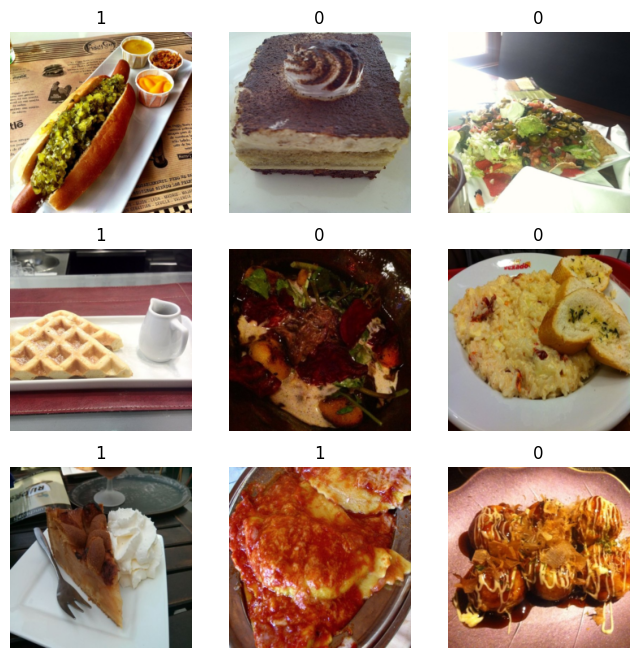

In [ ]:
rows, cols = 3, 3
with torch.no_grad():
  for imgs, _ in test_dl:
    logits = model_best(imgs.to(device)).squeeze()
    probs = F.sigmoid(logits)
    test_labels = (probs > 0.5).int()

    figure = plt.figure(figsize=(8, 8))
    for i in range(0, rows*cols):
      img, label = imgs[i], test_labels[i].item()
      figure.add_subplot(rows, cols, i+1);
      plt.title(label)
      plt.axis('off')
      plt.imshow(img.permute(1,2,0))
    plt.show()

    break

In [ ]:
# prints currently alive Tensors and Variables
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([64, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 1])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([64, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([64, 

/usr/local/lib/python3.10/dist-packages/torch/distributed/distributed_c10d.py:293: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


<class 'torch.Tensor'> torch.Size([750])
<class 'torch.Tensor'> torch.Size([63000])
<class 'torch.Tensor'> torch.Size([12000])
<class 'torch.Tensor'> torch.Size([75000])
<class 'torch.Tensor'> torch.Size([600])
<class 'torch.Tensor'> torch.Size([150])
<class 'torch.Tensor'> torch.Size([60000])
<class 'torch.Tensor'> torch.Size([15000])
<class 'torch.Tensor'> torch.Size([60600])
<class 'torch.Tensor'> torch.Size([15150])
<class 'torch.Tensor'> torch.Size([60600])
<class 'torch.Tensor'> torch.Size([15150])
